In [10]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

In [11]:
# read in dataset
dset = pd.read_csv('file.csv',sep = ',') # read in dataset

In [12]:
#Variables
f=10

print("Sampling rate: " + str(f) + "Hz")
print(str(dset.shape[0]) + " Data points")
print(str(dset.shape[0]/(f*60)) + " Minutes")

Sampling rate: 10Hz
157103 Data points
261.8383333333333 Minutes


In [13]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
#d = pd.DataFrame(data = dset[0:dset.shape[0]]) #Picking all the data
d = pd.DataFrame(data = dset[69910:85670]) #Select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/f) # add timestamp assuming 10 samples / second

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen
#d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
#d['bmav'] = d['belly'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
#d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
#d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
#d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]>0].values[-10:])
#d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]<0].values[-10:])
#d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
#d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
#d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
#d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
#d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

#d['brmav'] = d['brlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
#d['bfmav'] = d['bflast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
#d['brfmav'] = (d['brmav']+ d['bfmav'])/2

# movement data acceleration
d['acc'] = (d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])).apply(np.sqrt)

# movement data angular velocity
d['gyr'] = (d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])).apply(np.sqrt)

Autonomic: 7.64333333333 minutes
Autonomic light: 15.3166666667 minutes
Normal breathing: 2.03333333333 minutes
Cardio: 0.331666666667 minutes
Total: 25.325 minutes


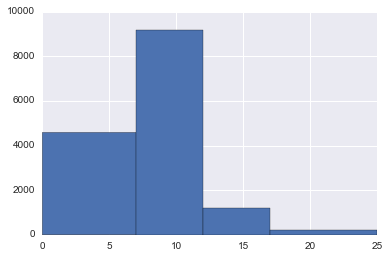

In [14]:
#Calculate the occurrence of each breathing type
occurrence=d['rfmav'].hist(bins=[0,7,12,17,25])
def get_hist(ax):
    n=[]
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        n.append(y1-y0)
    return n
n = get_hist(occurrence)

b1=n[0]/(60*f)
b2=n[1]/(60*f)
b3=n[2]/(60*f)
b4=n[3]/(60*f)

print("Autonomic: " + str(b1) + " minutes")
print("Autonomic light: " + str(b2) + " minutes")
print("Normal breathing: " + str(b3) + " minutes")
print("Cardio: " + str(b4) + " minutes")
print("Total: " + str(b1+b2+b3+b4) + " minutes")

In [15]:
f=d

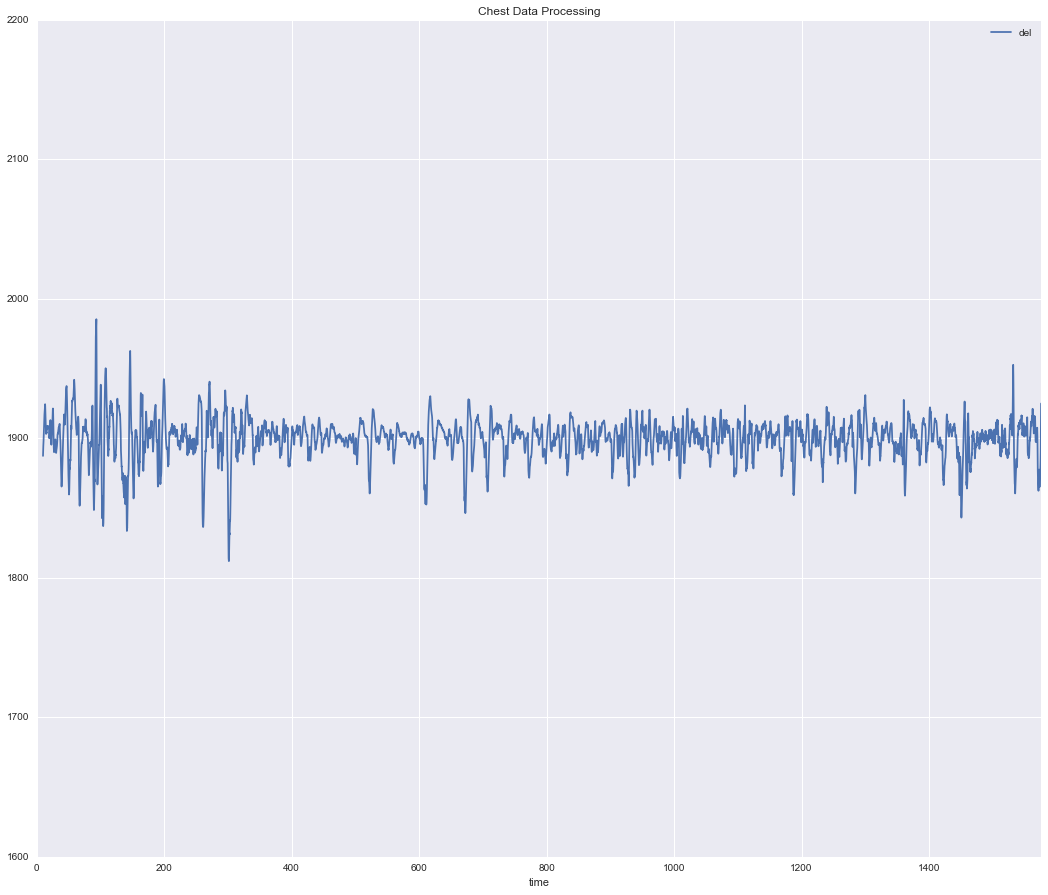

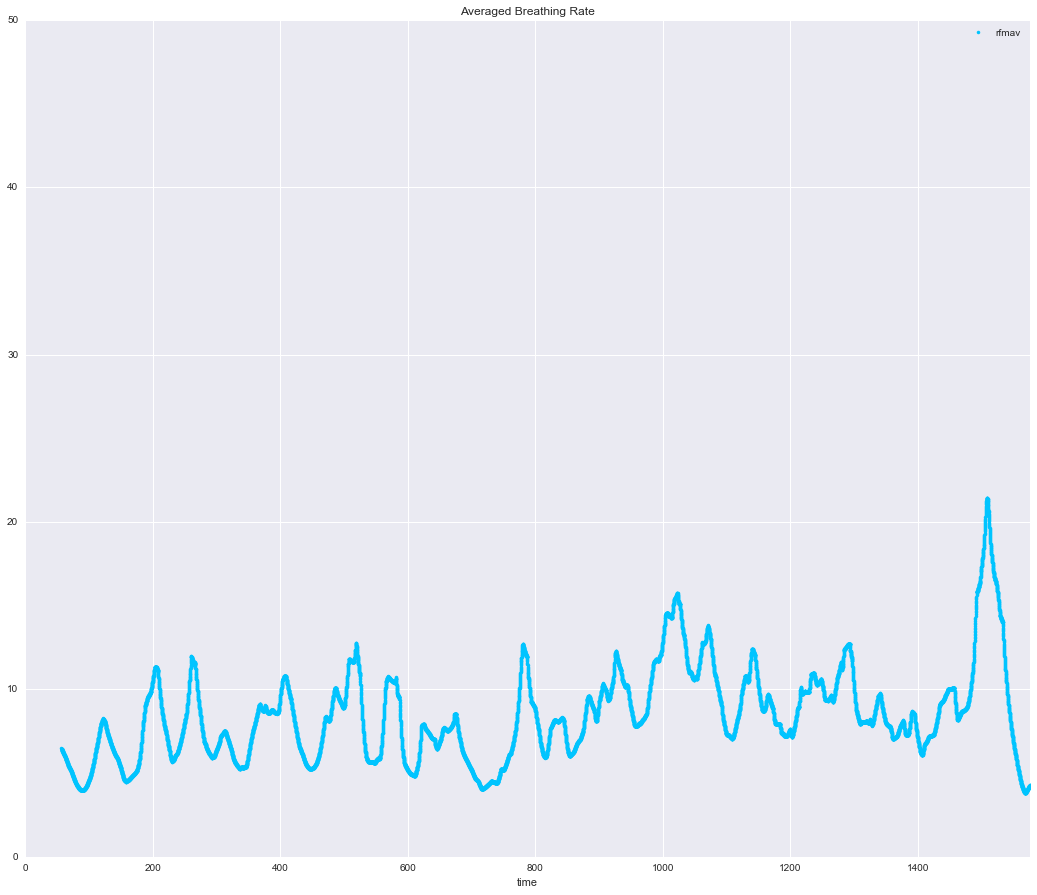

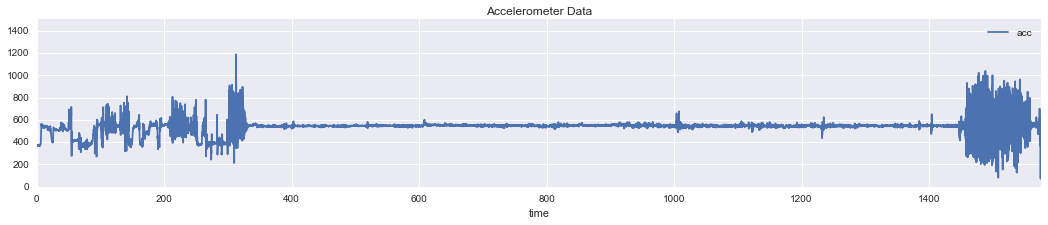

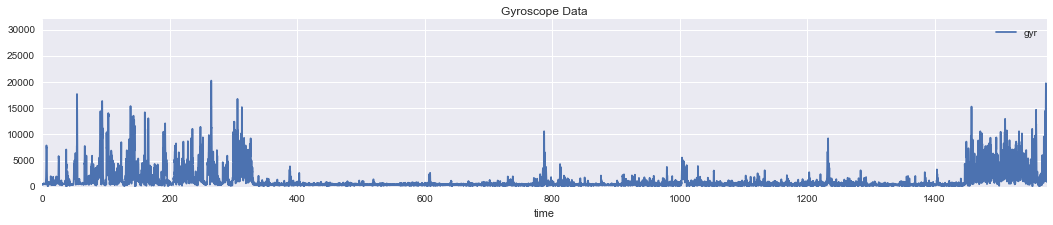

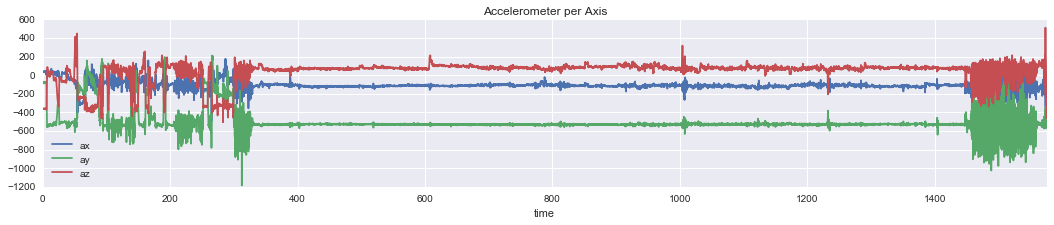

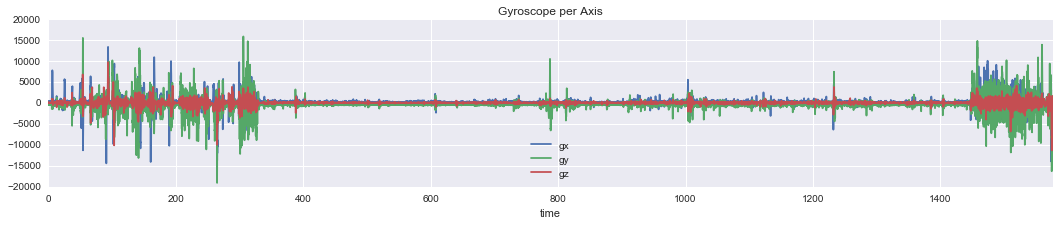

In [16]:
# this is just for plotting data 
g = d
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
#g['b2'] = 1600
#g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1600,2200), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,50), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3), ylim=(0,1500), title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3), ylim=(0,32000), title = 'Gyroscope Data')
d.plot(x = 'time',y = ['ax','ay','az'],figsize = (18,3), title = 'Accelerometer per Axis')
d.plot(x = 'time',y = ['gx','gy','gz'],figsize = (18,3), title = 'Gyroscope per Axis')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [17]:
print(d[::1000]) # every thousandth line of the processed dataset

       index  chest  belly   ax   ay   az    gx    gy   gz    time  ...   \
0          0   1797   1888   31  -81 -360   285  -349  182     0.0  ...    
1000    1000   1853   1853  -68 -541   76    74 -1338 -350   100.0  ...    
2000    2000   1791   1825 -104 -532   86   423  -459  138   200.0  ...    
3000    3000   1728   1710    6 -474   -2  2978 -6600 -791   300.0  ...    
4000    4000   1795   1841  -97 -509   39   166  -587   35   400.0  ...    
5000    5000   1845   1894 -114 -532   92   187  -305   57   500.0  ...    
6000    6000   1863   1907 -106 -525   60   394  -332  128   600.0  ...    
7000    7000   1849   1894 -101 -529   71  -385  -321 -116   700.0  ...    
8000    8000   1804   1899 -101 -528   48   288  -543  -18   800.0  ...    
9000    9000   1818   1897 -117 -525   83    21  -309   74   900.0  ...    
10000  10000   1782   1911 -104 -529   72   -23  -450  160  1000.0  ...    
11000  11000   1777   1936 -109 -530   73   192  -208  112  1100.0  ...    
12000  12000

In [18]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,rbtime,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1
0,0,1797,1888,31,-81,-360,285,-349,182,0.0,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,370.299878,485.952673,1900
1,1,1783,1887,31,-80,-365,352,-322,162,0.1,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,374.947996,503.817427,1900
2,2,1776,1882,30,-82,-360,437,-332,175,0.2,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,370.437579,576.036457,1900
3,3,1765,1880,31,-84,-359,374,-316,133,0.3,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,369.997297,507.366731,1900
4,4,1751,1877,31,-87,-360,330,-261,79,0.4,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,371.658445,428.091112,1900
5,5,1756,1878,38,-81,-362,276,-305,10,0.5,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,372.892746,411.462027,1900
6,6,1758,1874,38,-80,-360,276,-228,76,0.6,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,370.734406,365.972677,1900
7,7,1752,1870,38,-81,-360,340,-368,99,0.7,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,370.951479,510.710290,1900
8,8,1752,1873,33,-82,-361,333,-397,97,0.8,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,371.663827,527.168853,1900
9,9,1745,1870,38,-77,-360,378,-351,126,0.9,...,[nan],[nan],NaN,NaN,NaN,NaN,NaN,370.098636,531.000000,1900
